# USP - Introdução à Ciência de Dados

**University of São Paulo - School of Pharmaceutical Sciences of Ribeirão Preto (FCFRP)**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LucasVmigotto/usp-fcfrp-introducao-a-ciencia-de-dados/blob/develop/notebooks/lab.ipynb)

## Sumário

* [1. Estruturas de Dados](#1-estruturas-de-dados)
* [2. Estruturas de Decisão](#2-estruturas-de-decisão)
* [3. Estruturas de Repetição](#3-estruturas-de-repetição)
* [4. Funções](#4-funções)
* [5. NumPy](#5-numpy)
* [6. Pandas](#6-pandas)
* [7. Regressão](#7-regressão)
* [8. Classificação](#8-classificação)
* [9. Agrupamento](#9-agrupamento)
* [10. Referências](#10-referências)

## 0. Setup de Ambiente

### 0.1. Instalação de libs

In [ ]:
%%writefile requirements.txt
matplotlib==3.7.1
numpy==1.25.2
pandas==2.0.3
openpyxl==3.1.5
scikit-learn==1.2.2
seaborn==0.13.1

In [ ]:
! pip install -r requirements.txt

### 0.2. Importação de libs

In [123]:
from glob import glob
from json import dumps as json_dumps
from pathlib import Path
from typing import Any
from urllib.request import urlretrieve
from zipfile import ZipFile

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import ndarray
from pandas import DataFrame
from requests import Response
from requests import get as req_get
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from ucimlrepo import fetch_ucirepo

### 0.3. Definição de constantes

In [192]:
# @markdown **URL dos Datasets usados**

REGRESSION_DATASET_URL: str = 'https://archive.ics.uci.edu/static/public/477/real+estate+valuation+data+set.zip' # @param {type: "string"}
CLASSIFICATION_DATASET_URL: str = 'https://archive.ics.uci.edu/static/public/519/heart+failure+clinical+records.zip' # @param {type: "string"}
DECOMPOSITION_DATASET_URL: str = 'https://archive.ics.uci.edu/static/public/862/turkish+music+emotion.zip' # @param {type: "string"}

# @markdown ---

# @markdown **Local de armazenamento dos Datasets**
__DATA_BASE_PATH_VALUE: str = './data/' # @param {type: "string"}
DATA_BASE_PATH: Path = Path(__DATA_BASE_PATH_VALUE)

__REGRESSION_DATA_PATH_VALUE: str = 'regression' # @param {type: "string"}
REGRESSION_DATA_PATH: Path = DATA_BASE_PATH / __REGRESSION_DATA_PATH_VALUE

__CLASSIFICATION_DATA_PATH_VALUE: str = 'classification' # @param {type: "string"}
CLASSIFICATION_DATA_PATH: Path = DATA_BASE_PATH / __CLASSIFICATION_DATA_PATH_VALUE

__DECOMPOSITION_DATA_PATH_VALUE: str = 'decomposition' # @param {type: "string"}
DECOMPOSITION_DATA_PATH: Path = DATA_BASE_PATH / __DECOMPOSITION_DATA_PATH_VALUE

# @markdown ---

# @markdown **Preferências para treinamento dos modelos**

SEED: int = 42 # @param {type: "number"}
VERBOSE: bool = True # @param {type: "boolean"}
TEST_RATIO: int = 0.15 # @param {type: "slider", min: 0.1, max: 0.9, step: 0.05}
K_FOLDS: int = 10 # @param {type: "slider", min: 3, max: 10, step: 1}
N_NEIGHBORS: int = 5 # @param {type: "slider", min: 2, max: 10, step: 1}


In [5]:
DATA_BASE_PATH.mkdir(parents=True, exist_ok=True)
REGRESSION_DATA_PATH.mkdir(parents=True, exist_ok=True)
CLASSIFICATION_DATA_PATH.mkdir(parents=True, exist_ok=True)
DECOMPOSITION_DATA_PATH.mkdir(parents=True, exist_ok=True)

In [6]:
np.random.seed(SEED)

In [7]:
def download_dataset(
    url: str,
    destination_folder: Path,
    dataset_filename: str,
    on_retry: bool=False
) -> Path | None:
    try:
        destination: Path = destination_folder / dataset_filename

        urlretrieve(
            url,
            destination
        )

        if not destination.exists():
            raise Exception('Dataset não foi salvo.')

        return destination

    except Exception as err:
        print(err)
        if not on_retry:
            print('Não foi possível baixar, tentando novamente...')
            return download_dataset(
                url,
                destination_folder,
                dataset_filename,
                on_retry=True
            )

        return False


## 1. Estruturas de Dados

### 1.1. Lista de temperaturas

Crie uma lista de temperaturas de [dez países](https://pt.wikipedia.org/wiki/Lista_de_pa%C3%ADses_por_extremos_meteorol%C3%B3gicos). Escreva em cada célula de um notebook o acesso a elementos da lista para calcular a temperatura em graus Fahrenheit:

$$
C=5 \cdot \frac{F - 32}{9}
$$


In [8]:
WIKIPEDIA_COUNTRIES: str = 'https://pt.wikipedia.org/wiki/Lista_de_pa%C3%ADses_por_extremos_meteorol%C3%B3gicos'

df_temperature: DataFrame = pd.read_html(WIKIPEDIA_COUNTRIES)[0]

display(df_temperature.head())
df_temperature.info()

,País/Região,Temperatura mais baixa,Local,Data,Temperatura mais alta,Local.1,Data.1
0,África do Sul,-20.1 ºC,"Buffelsfontein, perto de Molteno, Cabo Oriental",23 de agosto de 2013[1],50.0 ºC,"Dunbrody, Cabo Oriental",3 de novembro de 1918[2]
1,Argélia,-13.8 ºC,Mécheria,28 de janeiro de 2005[3],51.3 ºC,"El Bayadh, El Bayadh",2 de setembro de 1979[3]
2,Botswana,NaN,NaN,NaN,44.0 ºC,Maun,7 de janeiro de 2016[4]
3,Burquina Fasso,5 ºC,Markoye,janeiro de 1975[5],47.2 ºC,Dori,1984[5]
4,Chade,NaN,NaN,NaN,47.6 ºC,Faya-Largeau,22 de junho de 2010[6]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   País/Região             116 non-null    object
 1   Temperatura mais baixa  95 non-null     object
 2   Local                   94 non-null     object
 3   Data                    93 non-null     object
 4   Temperatura mais alta   110 non-null    object
 5   Local.1                 110 non-null    object
 6   Data.1                  109 non-null    object
dtypes: object(7)
memory usage: 6.5+ KB


In [9]:
df_temperature = df_temperature.dropna().reset_index(drop=True)

df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   País/Região             87 non-null     object
 1   Temperatura mais baixa  87 non-null     object
 2   Local                   87 non-null     object
 3   Data                    87 non-null     object
 4   Temperatura mais alta   87 non-null     object
 5   Local.1                 87 non-null     object
 6   Data.1                  87 non-null     object
dtypes: object(7)
memory usage: 4.9+ KB


In [10]:
COUNTRY_COLUMNS: dict[str, str] = {
    'País/Região': 'country',
    'Temperatura mais baixa': 'lowest_temp',
    'Temperatura mais alta': 'highest_temp'
}

df_ten_temperatures = df_temperature.sample(10)[COUNTRY_COLUMNS.keys()].rename(columns=COUNTRY_COLUMNS)

df_ten_temperatures.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 76 to 68
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       10 non-null     object
 1   lowest_temp   10 non-null     object
 2   highest_temp  10 non-null     object
dtypes: object(3)
memory usage: 320.0+ bytes


In [11]:
def celsius_to_fahrenheit(celsius: float) -> float:
    return celsius * (9 / 5) + 32


def fahrenheit_to_celsius(fahrenheit: float) -> float:
    return fahrenheit - 32 * (5 / 9)

In [12]:
EXTRACT_TEMP: str = r'(-?\d{1,2}\.?\d?)'

df_ten_temperatures['highest_temp'] = df_ten_temperatures['highest_temp'].str.extract(EXTRACT_TEMP).astype(float)
df_ten_temperatures['lowest_temp'] = df_ten_temperatures['lowest_temp'].str.extract(EXTRACT_TEMP).astype(float)

df_ten_temperatures

,country,lowest_temp,highest_temp
76,Panamá,2.0,40.0
0,África do Sul,-20.1,50.0
26,Coreia do Sul,-32.8,40.0
22,Myanmar,-6.0,47.2
12,Hong Kong,-6.0,37.9
67,Suíça,-41.8,41.5
10,Camboja,10.0,42.6
18,Quirguistão,-53.6,44.0
4,Essuatíni,-6.7,47.7
68,Ucrânia,-41.9,42.0


In [13]:
df_ten_temperatures['lowest_temp_fahrenheit'] = df_ten_temperatures['lowest_temp'].apply(celsius_to_fahrenheit)
df_ten_temperatures['highest_temp_fahrenheit'] = df_ten_temperatures['highest_temp'].apply(celsius_to_fahrenheit)

df_ten_temperatures

,country,lowest_temp,highest_temp,lowest_temp_fahrenheit,highest_temp_fahrenheit
76,Panamá,2.0,40.0,35.60,104.00
0,África do Sul,-20.1,50.0,-4.18,122.00
26,Coreia do Sul,-32.8,40.0,-27.04,104.00
22,Myanmar,-6.0,47.2,21.20,116.96
12,Hong Kong,-6.0,37.9,21.20,100.22
67,Suíça,-41.8,41.5,-43.24,106.70
10,Camboja,10.0,42.6,50.00,108.68
18,Quirguistão,-53.6,44.0,-64.48,111.20
4,Essuatíni,-6.7,47.7,19.94,117.86
68,Ucrânia,-41.9,42.0,-43.42,107.60


### 1.2. Altura média por país

Tendo como dados de entrada a [altura média por país](https://pt.wikipedia.org/wiki/Estatura) crie um dicionário com 10 países, com chave como nome do país e valor como altura média, imprima em cada linha de um notebook o peso ideal:

$$
\text{Peso Ideal} = 72 \cdot \text{Altura} - 58
$$

por país, utilizando um dicionário e o operador de formatação [`f''`](https://docs.python.org/3/tutorial/inputoutput.html#formatted-string-literals)


In [14]:
WIKIPEDIA_AVG_HEIGHT: str = 'https://pt.wikipedia.org/wiki/Estatura'

df_heights: DataFrame = pd.read_html(WIKIPEDIA_AVG_HEIGHT)[1]

df_heights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   País                             84 non-null     object
 1   Altura média masculina           84 non-null     object
 2   Altura média feminina            74 non-null     object
 3   Grupo de idade toda a populaçao  84 non-null     object
 4   Método                           76 non-null     object
 5   Ano                              80 non-null     object
 6   Fonte                            84 non-null     object
dtypes: object(7)
memory usage: 4.7+ KB


In [15]:
HEIGHTS_COLUMNS: dict[str, str] = {
    'País': 'country',
    'Altura média masculina': 'avg_height_male',
    'Altura média feminina': 'avg_height_female'
}

df_ten_heights = df_heights.dropna().reset_index(drop=True)

df_ten_heights = df_ten_heights[HEIGHTS_COLUMNS.keys()].sample(10).rename(columns=HEIGHTS_COLUMNS)

df_ten_heights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 1 to 15
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   country            10 non-null     object
 1   avg_height_male    10 non-null     object
 2   avg_height_female  10 non-null     object
dtypes: object(3)
memory usage: 320.0+ bytes


In [16]:
HEIGHT_EXTRACT: str = r'(\d{2,3}[,\.]\d)'

df_ten_heights['avg_height_male'] = df_ten_heights['avg_height_male'].str.extract(HEIGHT_EXTRACT)[0].str.replace(',', '.').astype(float)
df_ten_heights['avg_height_female'] = df_ten_heights['avg_height_female'].str.extract(HEIGHT_EXTRACT)[0].str.replace(',', '.').astype(float)
df_ten_heights['avg_height'] = (df_ten_heights['avg_height_male'] + df_ten_heights['avg_height_female']) / 2

df_ten_heights

,country,avg_height_male,avg_height_female,avg_height
1,Alemanha,181.0,168.0,174.50
49,México,167.0,155.0,161.00
5,Argentina,174.3,161.1,167.70
54,Peru,166.5,155.4,160.95
29,Estados Unidos,175.3,161.3,168.30
63,Tailândia,167.1,156.6,161.85
17,Coreia do Sul,173.5,160.3,166.90
3,Argentina,173.8,161.1,167.45
18,Chile,171.2,157.2,164.20
15,Canadá,174.0,161.0,167.50


In [17]:
dict_heights: dict[str, float] = {row['country']: row['avg_height']
                                  for _idx, row in df_ten_heights.iterrows()}

dict_heights

{'Alemanha': 174.5,
 'México': 161.0,
 'Argentina': 167.45,
 'Peru': 160.95,
 'Estados Unidos': 168.3,
 'Tailândia': 161.85,
 'Coreia do Sul': 166.9,
 'Chile': 164.2,
 'Canadá': 167.5}

In [18]:
def ideal_weight(height: float) -> float:
    return height * 72 - 58

In [19]:
for key, value in dict_heights.items():
    print(f'{key:>15} => Average height: {value:.2f} | Ideal weight: {ideal_weight(value) / 100:.2f}')

       Alemanha => Average height: 174.50 | Ideal weight: 125.06
         México => Average height: 161.00 | Ideal weight: 115.34
      Argentina => Average height: 167.45 | Ideal weight: 119.98
           Peru => Average height: 160.95 | Ideal weight: 115.30
 Estados Unidos => Average height: 168.30 | Ideal weight: 120.60
      Tailândia => Average height: 161.85 | Ideal weight: 115.95
  Coreia do Sul => Average height: 166.90 | Ideal weight: 119.59
          Chile => Average height: 164.20 | Ideal weight: 117.64
         Canadá => Average height: 167.50 | Ideal weight: 120.02


### 1.3. Conversão de valor de bolsa de estudos

Faça a conversão do valor de bolsas de pós-graduação de [três países](https://exame.abril.com.br/carreira/confira-63-bolsas-para-estudar-em-paises-como-canada-eua-e-alemanha/) para Reais, imprimindo o salário de uma jornada de 40h semanais:
* Por hora trabalhada;
* Por mês;
* Por ano.


In [20]:
CURRENCY_API_URL: str = 'https://economia.awesomeapi.com.br/json/last/'

CURRENCIES: dict[str, str] = {
    'USD': 'USD-BRL',
    'EUR': 'EUR-BRL'
}

def get_currency_for(currency: str) -> float:
    try:
        response: Response = req_get(f'{CURRENCY_API_URL}/{currency}')

        if response.status_code != 200:
            raise Exception('Response was not successfully completed')

        return float(response.json()[currency.replace('-', '')]['bid'])

    except Exception:
        return 0


> [...]
>
> **CAPES e DAAD oferecem bolsas para doutorado na Alemanha**
>
> A CAPES e o DAAD (serviço alemão de intercâmbio acadêmico) estão recebendo inscrições para bolsas de doutorado na Alemanha. Estão disponíveis bolsas tanto para doutorado pleno quanto para estadias mais curtas, como doutorado sanduíche ou doutorado com cotutela. As inscrições vão até 20 de dezembro.
>
> São até 20 bolsas para doutorado pleno (com duração de até quatro anos), 22 bolsas para doutorado sanduíche curto (entre quatro e 12 meses), 15 bolsas para doutorado sanduíche longo (de 12 a 24 meses) e oito bolsas para o doutorado com cotutela (entre quatro e 18 meses). Os bolsistas receberão um valor mensal de 1.200 euros para arcar com os custos de vida na Alemanha. A bolsa também cobre o seguro saúde para os estudantes e oferece um auxílio de 1.575 euros para despesas com passagem aérea. Esse último valor será depositado na Alemanha junto com a primeira mensalidade da bolsa. O edital também cita um auxílio-instalação e um auxílio-dependente (este último apenas para doutorado pleno), cujos valores não são especificados.
>
> [...]

In [21]:
MONTHLY: float = 1200. # 1200 por mês

EURO_RATE: float = get_currency_for(CURRENCIES['EUR'])

print('Hour (40h week): R$ {:,.2f}'.format((MONTHLY / (24 * 30)) * EURO_RATE))
print('Month: R$ {:,.2f}'.format(MONTHLY * EURO_RATE))
print('Year: R$ {:,.2f}'.format((MONTHLY * EURO_RATE) * 12))

Hour (40h week): R$ 10.16
Month: R$ 7,312.80
Year: R$ 87,753.60


> [...]
>
> **Bolsas de estudo para mestrado em saúde pública**
>
> Estão abertas as candidaturas para o programa “EUROPUBHEALTH” de mestrado em saúde pública na Europa, promovido pela Comissão Europeia. As inscrições para as bolsas de excelência disponíveis (cuja quantidade ainda não foi informada) podem ser realizadas até 15 de janeiro, pelo site.
>
> Para o ano letivo 2020-2022, serão distribuídas bolsas de excelência no valor de, no máximo, 46 mil euros pelos dois anos, além de bolsas adicionais especialmente destinadas aos melhores alunos de algumas regiões prioritárias – incluindo América Latina. Esse valor cobre os custos de participação no programa,até três mil euros em passagens aéreas por ano, um auxílio-instalação de mil euros, e uma mesada de mil euros para ajudar com o custo de vida.
>
> [...]

In [22]:
MONTHLY: float = 1000. # 1200 por mês

EURO_RATE: float = get_currency_for(CURRENCIES['EUR'])

print('Hour (40h week): R$ {:,.2f}'.format((MONTHLY / (24 * 30)) * EURO_RATE))
print('Month: R$ {:,.2f}'.format(MONTHLY * EURO_RATE))
print('Year: R$ {:,.2f}'.format((MONTHLY * EURO_RATE) * 12))

Hour (40h week): R$ 8.46
Month: R$ 6,094.00
Year: R$ 73,128.00


> [...]
>
> **Bolsas de estudo integrais de pós em Abu Dhabi**
>
> A Khalifa University está recebendo inscrições para bolsas integrais de pós-graduação em Abu Dhabi, onde está sediada. As bolsas contemplam tanto os programas 14 de mestrado > quanto os 12 de doutorado oferecidos pela universidade. As inscrições vão até 3 de novembro para ingresso em janeiro de 2020, ou até fevereiro de 2020 para ingresso em agosto.
>
> A lista completa dos programas oferecidos pela instituição pode ser vista neste link, sob a aba “Academic”. As bolsas integrais para pós-graduação em Abu Dhabi cobrem totalmente os custos de tuition do programa e incluem passagens aéreas anuais. Também cobrem seguro de saúde e um valor de US$ 2.200 a US$ 2.700 por mês para ajuda com os custos de vida no país.
>
> [...]

In [23]:
MONTHLY: float = ((2200 + 2700) / 2) # Média de 2200 e 2700 por mês

EURO_RATE: float = get_currency_for(CURRENCIES['USD'])

print('Hour (40h week): R$ {:,.2f}'.format((MONTHLY / (24 * 30)) * EURO_RATE))
print('Month: R$ {:,.2f}'.format(MONTHLY * EURO_RATE))
print('Year: R$ {:,.2f}'.format((MONTHLY * EURO_RATE) * 12))

Hour (40h week): R$ 19.04
Month: R$ 13,710.69
Year: R$ 164,528.28


## 2. Estruturas de Decisão

### 2.1. Está frio?

Escreva código em uma célula, para, dado o elemento de uma lista de temperaturas acima, imprimir "`está frio`" se a temperatura for menor que um valor de uma variável `t` definida por você ou "`está calor`" caso contrário.

In [24]:
t: float = 15 # 10 graus Celsius como threshold

In [25]:
df_ten_temperatures['average_temperature'] = df_ten_temperatures['highest_temp'] + df_ten_temperatures['lowest_temp'] / 2

df_ten_temperatures

,country,lowest_temp,highest_temp,lowest_temp_fahrenheit,highest_temp_fahrenheit,average_temperature
76,Panamá,2.0,40.0,35.60,104.00,41.00
0,África do Sul,-20.1,50.0,-4.18,122.00,39.95
26,Coreia do Sul,-32.8,40.0,-27.04,104.00,23.60
22,Myanmar,-6.0,47.2,21.20,116.96,44.20
12,Hong Kong,-6.0,37.9,21.20,100.22,34.90
67,Suíça,-41.8,41.5,-43.24,106.70,20.60
10,Camboja,10.0,42.6,50.00,108.68,47.60
18,Quirguistão,-53.6,44.0,-64.48,111.20,17.20
4,Essuatíni,-6.7,47.7,19.94,117.86,44.35
68,Ucrânia,-41.9,42.0,-43.42,107.60,21.05


In [26]:
for country, temperature in df_ten_temperatures[['country', 'average_temperature']].values:
  print(f'Em {country}', 'está frio' if temperature < t else 'está calor')

Em Panamá está calor
Em África do Sul está calor
Em Coreia do Sul está calor
Em Myanmar está calor
Em Hong Kong está calor
Em Suíça está calor
Em Camboja está calor
Em Quirguistão está calor
Em Essuatíni está calor
Em Ucrânia está calor


### 2.2. Combustíveis

Um posto está vendendo combustíveis com a seguinte tabela de descontos:

|  Volume  |         Álcool         |        Gasolina        |
|---------:|:----------------------:|:-----------------------|
|$\lt{20l}$|desconto de $3%$ por $l$|desconto de $4%$ por $l$|
|$\ge{20l}$|desconto de $5%$ por $l$|desconto de $6%$ por $l$|

Escreva um código que leia o número de litros vendidos, o tipo de combustível (codificado da seguinte forma: A-álcool, G-gasolina), calcule e imprima o valor a ser pago pelo cliente sabendo-se que o preço do litro da gasolina é 2,50 reais, e o preço do litro do álcool é de 1,90 reais.


In [27]:
FUEL_PROMPT_VALUE_MESSAGE: str = 'Quantidade de combustível vendido (em Litros): '
FUEL_PROMPT_TYPE_MESSAGE: str = 'Tipo de combustível vendido\n' \
                                + '(A para Álcool ou G para Gasolina): '
FUEL_TYPES: dict[str, dict[str, str | float | dict[int, float]]] = {
    'G': {
        'name': 'Gasolina',
        'price': 2.5,
        'discount': {1: .3, 0: .4}
    },
    'A': {
        'name': 'Álcool',
        'price': 1.9,
        'discount': {1: .5, 0: .6}
    }
}
FUEL_EXCEPTION_MESSAGE: str = 'Valor inválido. Por favor, insira a quantidade em litros'
FUEL_DISCOUNT_THRESHOLD: int = 20


In [28]:
while True:
  try:
    fuel_sold: float = float(input(FUEL_PROMPT_VALUE_MESSAGE).replace(',', '.'))

    if (fuel_type := input(FUEL_PROMPT_TYPE_MESSAGE).upper()) not in FUEL_TYPES.keys():
      raise Exception(f'Tipo de combustível {fuel_type} não é válido')

    break

  except ValueError:
    print(FUEL_EXCEPTION_MESSAGE)
    continue

  except KeyboardInterrupt:
    break

  except Exception as err:
    print(err)
    continue

In [29]:
def calculate_final_fuel_price(
    base_price: float,
    fuel_sold: float,
    discount_rate: float
) -> float:
  return base_price * (1 - discount_rate) * fuel_sold


In [30]:
final_price: float = calculate_final_fuel_price(
    FUEL_TYPES[fuel_type]['price'],
    fuel_sold,
    FUEL_TYPES[fuel_type]['discount'][fuel_sold < FUEL_DISCOUNT_THRESHOLD]
)

print(f"{fuel_sold:.1f}L de {FUEL_TYPES[fuel_type]['name']} custam R$ {final_price:,.2f}")

25.0L de Álcool custam R$ 19.00


### 2.3. Frutaria

Uma fruteira está vendendo frutas com a seguinte tabela de preços:

|Fruta|$\lt{5}\text{Kg}$|$\ge{5}\text{Kg}$|
|-:|:-:|:-|
|Morango|2,50 reais por kilo|2,20 reais por kilo|
|Maçã|1,80 reais por kilo|1,50 reais por kilo|

Se o cliente comprar mais de 8 Kg em frutas ou o valor total da compra ultrapassar R$ 25,00, receberá ainda um desconto de 10% sobre este total. Escreva código para ler a quantidade (em Kg) de morangos e a quantidade (em Kg) de maças adquiridas e escreva o valor a ser pago pelo cliente.

In [31]:
FRUIT_PROMPT_TEMPLATE: str = 'Informe a quantidade de {fruit} (em Kg.): '
FRUIT_TYPES: dict[str, dict[int, float]] = {
    'Morango': {1: 2.5, 0: 2.2},
    'Maçã': {1: 1.8, 0: 1.5},
}

FRUIT_PRICE_THRESHOLD: int = 5
FRUIT_PRICE_DISCOUNT_THRESHOLD: int = 25
FRUIT_QUANTITY_DISCOUNT_THRESHOLD: int = 8
FRUIT_DISCOUNT_VALUE: int = .1

In [32]:
def get_fruit_input(prompt: str) -> tuple[int]:
  while True:
    try:
      return int(input(prompt))
      break
    except ValueError:
      continue
    except (Exception, KeyboardInterrupt):
      break


In [33]:
shop_cart: set[tuple[str, int]] = set()

for fruit in FRUIT_TYPES.keys():
  shop_cart.add((
      fruit,
      get_fruit_input(FRUIT_PROMPT_TEMPLATE.format(fruit=fruit))
  ))

In [34]:
def fruit_calculate_final_price(
    base_price: float,
    fruit_sold: int
) -> float:
    return base_price * fruit_sold


In [35]:
final_price: float = sum(fruit_calculate_final_price(
                            FRUIT_TYPES[fruit][quantity < FRUIT_PRICE_THRESHOLD],
                            quantity
                        )
                        for (fruit, quantity) in shop_cart)

if (
    sum(quantity for (_, quantity) in shop_cart) > FRUIT_QUANTITY_DISCOUNT_THRESHOLD
    or final_price > FRUIT_PRICE_DISCOUNT_THRESHOLD
):
  final_price *= 1 - FRUIT_DISCOUNT_VALUE

print(f'Total a pagar: R$ {final_price:,.2f}')

Total a pagar: R$ 39.96


## 3. Estruturas de Repetição

### 3.1. Tabuada

Desenvolva um gerador de tabuada, capaz de gerar a tabuada de qualquer número inteiro entre 1 a 10. Dada uma variável k em uma célula calcular a tabuada para o número. A saída deve ser conforme o exemplo abaixo:

```text
Tabuado de 5:
5 X 1 = 5
5 X 2 = 10
...
5 X 10 = 50
```

In [36]:
MULTIPLICATION_PROMPT: str = 'Insira o número que você deseja a tabuada: '

In [37]:
while True:
  try:
    number = int(input(MULTIPLICATION_PROMPT))
    break
  except ValueError:
    continue

In [38]:
for idx in range(1, 11):
  print(f'{number:02} X {idx:02} = {number * idx:02}')

05 X 01 = 05
05 X 02 = 10
05 X 03 = 15
05 X 04 = 20
05 X 05 = 25
05 X 06 = 30
05 X 07 = 35
05 X 08 = 40
05 X 09 = 45
05 X 10 = 50


### 3.2. Repetição com temperaturas e alturas

Utilize uma estrutura de repetição para imprimir todos os elementos das listas de temperatura e altura criadas acima.

In [39]:
LABELS: tuple[str] = ('Temperaturas', 'Alturas')
dictionaries: list[dict[str, Any]] = []

for label, dataframe in zip(LABELS, (df_ten_temperatures, df_ten_heights)):
    print('Lista de', label)
    for _idx, row in dataframe.iterrows():
        dictionaries.append({key: value if isinstance(value, str) else round(value, 2) for key, value in row.items()})
        print(json_dumps(dictionaries[-1],
                         allow_nan=True,
                         indent=None))
    print('-' * 20)

Lista de Temperaturas
{"country": "Panam\u00e1", "lowest_temp": 2.0, "highest_temp": 40.0, "lowest_temp_fahrenheit": 35.6, "highest_temp_fahrenheit": 104.0, "average_temperature": 41.0}
{"country": "\u00c1frica do Sul", "lowest_temp": -20.1, "highest_temp": 50.0, "lowest_temp_fahrenheit": -4.18, "highest_temp_fahrenheit": 122.0, "average_temperature": 39.95}
{"country": "Coreia do Sul", "lowest_temp": -32.8, "highest_temp": 40.0, "lowest_temp_fahrenheit": -27.04, "highest_temp_fahrenheit": 104.0, "average_temperature": 23.6}
{"country": "Myanmar", "lowest_temp": -6.0, "highest_temp": 47.2, "lowest_temp_fahrenheit": 21.2, "highest_temp_fahrenheit": 116.96, "average_temperature": 44.2}
{"country": "Hong Kong", "lowest_temp": -6.0, "highest_temp": 37.9, "lowest_temp_fahrenheit": 21.2, "highest_temp_fahrenheit": 100.22, "average_temperature": 34.9}
{"country": "Su\u00ed\u00e7a", "lowest_temp": -41.8, "highest_temp": 41.5, "lowest_temp_fahrenheit": -43.24, "highest_temp_fahrenheit": 106.7, 

### 3.3. Repetindo e formatando

Acesse chaves e valores do dicionário criado acima, e imprima cada item utilizando o operador de formatação.

In [40]:
for dictionary in dictionaries:
    for key, value in dictionary.items():
      print(f'{key:<8} => {value if isinstance(value, str) else round(value, 2)}')
    print('-' * 20)

country  => Panamá
lowest_temp => 2.0
highest_temp => 40.0
lowest_temp_fahrenheit => 35.6
highest_temp_fahrenheit => 104.0
average_temperature => 41.0
--------------------
country  => África do Sul
lowest_temp => -20.1
highest_temp => 50.0
lowest_temp_fahrenheit => -4.18
highest_temp_fahrenheit => 122.0
average_temperature => 39.95
--------------------
country  => Coreia do Sul
lowest_temp => -32.8
highest_temp => 40.0
lowest_temp_fahrenheit => -27.04
highest_temp_fahrenheit => 104.0
average_temperature => 23.6
--------------------
country  => Myanmar
lowest_temp => -6.0
highest_temp => 47.2
lowest_temp_fahrenheit => 21.2
highest_temp_fahrenheit => 116.96
average_temperature => 44.2
--------------------
country  => Hong Kong
lowest_temp => -6.0
highest_temp => 37.9
lowest_temp_fahrenheit => 21.2
highest_temp_fahrenheit => 100.22
average_temperature => 34.9
--------------------
country  => Suíça
lowest_temp => -41.8
highest_temp => 41.5
lowest_temp_fahrenheit => -43.24
highest_temp_fahr

## 4. Funções

### 4.1. Invertendo

Faça uma função que retorne o reverso de um número inteiro informado.
> Por exemplo: `127 -> 721`

In [41]:
REVERSE_NUMBER_INPUT_PROMPT: str = 'Informe, por favor, um número: '

In [42]:
def reverse_number(number: int) -> int:
  return int(str(number)[::-1])


In [43]:
while True:
    try:
        print(reverse_number(int(input(REVERSE_NUMBER_INPUT_PROMPT))))
        break
    except ValueError:
        continue
    except (KeyboardInterrupt, Exception):
        break

721


### 4.2. Convertendo uma temperatura

Faça uma função para converter, que dado um valor numérico de temperatura e um valor de caractere para a escala (Celsius ou Farenheit) converta o número para a escala desejada e retorna o valor.

In [44]:
CONVERT_TEMPERATURE_VALUE_PROMPT: str = 'Informe o valor da temperatura para a conversão: '
CONVERT_TEMPERATURE_TYPE_PROMPT: str = 'Informe a escala para que seja convertida: '
CONVERT_TEMPERATURE_SCALES: tuple[str] = ('C', 'F')


In [45]:
def convert_temperature(temperature: float, scale: str) -> float:
    if scale not in CONVERT_TEMPERATURE_SCALES:
        raise ValueError()
    if scale == 'F':
        return celsius_to_fahrenheit(temperature)
    else:
        return fahrenheit_to_celsius(temperature)


In [46]:
while True:
    try:
        print(
            convert_temperature(
                float(input(CONVERT_TEMPERATURE_VALUE_PROMPT)),
                input(CONVERT_TEMPERATURE_TYPE_PROMPT)
            )
        )
        break
    except ValueError:
        continue
    except KeyboardInterrupt:
        break
    except Exception as err:
        print(err)
        continue

96.8


### 4.3. 24 para 12 horas com AM/PM

Faça uma programa que converta da notação de 24 horas para a notação de 12 horas. Por exemplo, o programa deve converter 14:25 em 2:25 P.M. A entrada é dada em dois inteiros.

In [47]:
CONVERT_TIME_HOURS_PROMPT: str = 'Informe o valor de horas: '
CONVERT_TIME_MINUTES_PROMPT: str = 'Informe o valor de minutos: '

In [48]:
def convert_time_notation(hours: int, minutes: int) -> str:
  if hours > 24 or not 0 <= minutes <= 60:
      raise ValueError()
  return f"{(hours if hours < 13 else hours -12):02}:{minutes:02} {'AM' if hours < 13 else 'PM'}"

In [49]:
while True:
    try:
        print(
            convert_time_notation(
                int(input(CONVERT_TIME_HOURS_PROMPT)),
                int(input(CONVERT_TIME_MINUTES_PROMPT))
            )
        )
        break
    except ValueError:
        continue
    except KeyboardInterrupt:
        break
    except Exception as err:
        print(err)
        continue

10:21 AM


## 5. NumPy

### 5.1. Primeira matriz NumPy

Escreva código para criar uma matriz 4 x 10, com números simulados de uma distribuição normal com média 10 e variância 5, e substitua todos os elementos da primeira coluna maiores que 12 por 0.

In [50]:
MEAN: int = 10
STANDARD_DEVIATION: int = 5
MATRIX_DIMS: tuple[int, int] = (4, 10)

In [51]:
matrix: ndarray = np.random.normal(loc=MEAN,
                                   scale=STANDARD_DEVIATION,
                                   size=MATRIX_DIMS)

matrix

array([[ 2.90701768, 10.95168492, 10.67876915, 13.04044831, 13.52490656,
        11.80461689,  2.66516057, 14.46314736,  9.47371433,  5.22326778],
       [ 7.92617683,  3.00629559,  8.27959729, 13.75392943,  8.36187408,
         5.69200973,  8.70907601, 12.30477808,  3.25305013,  4.90463607],
       [10.6350612 ,  3.75278139, 19.72557807,  9.23331771,  5.46506387,
         5.91322922,  7.58438661,  7.15085826, -0.45799835, 16.31870265],
       [ 9.9225833 ,  9.86311777, 14.08936756,  4.72697765,  6.2083644 ,
        12.28707824,  9.67810975, 11.72451168,  9.59956332,  8.79309934]])

In [52]:
matrix[:, 0][matrix[:, 0] > 12] = 0

matrix

array([[ 2.90701768, 10.95168492, 10.67876915, 13.04044831, 13.52490656,
        11.80461689,  2.66516057, 14.46314736,  9.47371433,  5.22326778],
       [ 7.92617683,  3.00629559,  8.27959729, 13.75392943,  8.36187408,
         5.69200973,  8.70907601, 12.30477808,  3.25305013,  4.90463607],
       [10.6350612 ,  3.75278139, 19.72557807,  9.23331771,  5.46506387,
         5.91322922,  7.58438661,  7.15085826, -0.45799835, 16.31870265],
       [ 9.9225833 ,  9.86311777, 14.08936756,  4.72697765,  6.2083644 ,
        12.28707824,  9.67810975, 11.72451168,  9.59956332,  8.79309934]])

### 5.2. Alturas, Pesos e Matrizes

Crie uma matriz 3x3 com 3 alturas de 3 países e calcule o peso ideal (fórmula acima) para multiplicar e somar aos elementos da matriz.

In [53]:
height_matrix: ndarray = df_ten_heights.loc[df_ten_heights.index[:-1], 'avg_height'].values.reshape(3,-1)

height_matrix

array([[174.5 , 161.  , 167.7 ],
       [160.95, 168.3 , 161.85],
       [166.9 , 167.45, 164.2 ]])

In [54]:
def ideal_weight_ndarray(heights: ndarray) -> ndarray:
    return heights * 78 - 58


In [55]:
height_matrix * (ideal_weight_ndarray(height_matrix) / 100)

array([[23649.985  , 20125.     , 21838.9002 ],
       [20112.47295, 21995.8002 , 20338.55655],
       [21630.5738 , 21773.69095, 20934.8432 ]])

In [56]:
height_matrix + (ideal_weight_ndarray(height_matrix) / 100)

array([[310.03 , 286.   , 297.926],
       [285.911, 298.994, 287.513],
       [296.502, 297.481, 291.696]])

### 5.3. NumPy the Hardway: No broadcasting 💪

Faça uma função que recebe dois parâmetros, uma matriz numpy e uma constante, e utiliza estruturas de repetição para multiplicar cada elemento da matriz e retorna a matriz multiplicada.

In [57]:
def ndarray_multiplication(array: ndarray, number: int | float) -> ndarray:
    clone = array.copy()

    for i in range(clone.shape[0]):
        for j in range(clone.shape[1]):
            clone[i, j] *= number

    return clone


In [58]:
ndarray_multiplication(
    np.random.randint(100, size=(10, 10)),
    7
)

array([[  0, 126,   7, 364, 301, 623, 217, 483, 217, 469],
       [378, 518, 385, 112, 259, 161, 476, 679, 483, 595],
       [ 70, 105, 672, 504, 406, 483, 553, 644,  14, 133],
       [406, 245, 126, 623, 462, 126, 133, 665, 490, 357],
       [224, 273, 266, 567,   0,  70, 637, 392, 616, 343],
       [154, 210, 651, 287, 686,  42, 105, 623, 413,   7],
       [  0, 329,  77, 476, 252, 217,  56, 686, 126, 329],
       [553,  14, 133, 161, 371, 224, 161, 518, 497, 245],
       [259, 581, 686, 616, 686, 168, 644, 119, 567, 455],
       [371, 238, 553, 420, 280, 693, 224, 469, 224,  91]])

## 6. Pandas

> Para os exercícios, utilize [este conjunto de dados](https://drive.google.com/open?id=1u1SEDTja9QC7MAj_VlQcxNtAhQfs-5YR)

### 6.0. Setup de dados

In [59]:
PANDAS_DATASET_URL: str = 'https://drive.usercontent.google.com/download?id=1u1SEDTja9QC7MAj_VlQcxNtAhQfs-5YR'
PANDAS_BIKE_DATASET: Path = Path(DATA_BASE_PATH / 'bike.csv')

In [60]:
try:
    urlretrieve(
        PANDAS_DATASET_URL,
        PANDAS_BIKE_DATASET
    )

    if not PANDAS_BIKE_DATASET.exists():
        raise Exception()

    print('Arquivo baixado com sucesso')

except Exception as err:
    print('O arquivo não pôde ser baixado')
    print(err)

Arquivo baixado com sucesso


In [61]:
df_pandas_bike: DataFrame = pd.read_csv(PANDAS_BIKE_DATASET)

df_pandas_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### 6.1. Explorando o [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)

Faça uma função, que dado um dataframe com os dados acima. imprime a média e o desvio padrão das variáveis 'season' e 'holiday'.

In [62]:
BIKE_COLUMNS_OUTPUT: set[str] = {'season', 'holiday'}

In [63]:
def output_mean_and_std(df: DataFrame, columns: list[str]) -> None:
    for column in columns:
        print(column,
            json_dumps({
                'mean': df[column].mean(),
                'standard_deviation': df[column].std(),
            }, indent=2)
        )


In [64]:
output_mean_and_std(df_pandas_bike, BIKE_COLUMNS_OUTPUT)

holiday {
  "mean": 0.02856880396839978,
  "standard_deviation": 0.16659885062470958
}
season {
  "mean": 2.5066139996325556,
  "standard_deviation": 1.116174309344325
}


### 6.2. Novas colunas, novos dados

Crie uma nova coluna no `dataframe`, com o nome `'month'` com o mês correspondente de cada linha da coluna `'datetime'` e escreva uma função que dado um `dataframe`, e um valor numérico entre 1 e 12, retorna um sub-`dataframe` para o mês requerido.

In [65]:
df_pandas_bike['datetime'] = pd.to_datetime(df_pandas_bike['datetime'])

df_pandas_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [66]:
df_pandas_bike['month'] = df_pandas_bike['datetime'].dt.month

In [67]:
def pandas_filter_df_per_month(
    df: DataFrame,
    month_column_name: str,
    month: int
) -> DataFrame:
    return df[df[month_column_name] == month]

In [68]:
pandas_filter_df_per_month(df_pandas_bike, 'month', 7).head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month
2690,2011-07-01 00:00:00,3,0,1,1,27.06,31.060,50,0.0,20,48,68,7
2691,2011-07-01 01:00:00,3,0,1,1,27.06,31.060,50,0.0,15,16,31,7
2692,2011-07-01 02:00:00,3,0,1,1,25.42,30.305,69,0.0,6,7,13,7
2693,2011-07-01 03:00:00,3,0,1,1,26.24,31.060,53,0.0,5,6,11,7
2694,2011-07-01 04:00:00,3,0,1,1,25.42,31.060,57,0.0,1,5,6,7


### 6.3. _Histogramando_ e _boxplotiando_ um pouco

Faça um histograma da variável `'temp'` e um boxplot único com a variável `'temp'` em cada `'month'` (no eixo x).


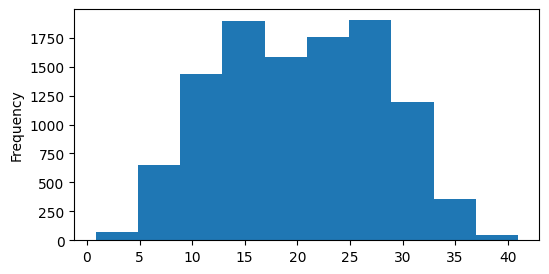

In [69]:
plt.subplots(figsize=(6, 3))

df_pandas_bike['temp'].plot(kind='hist')

plt.show()

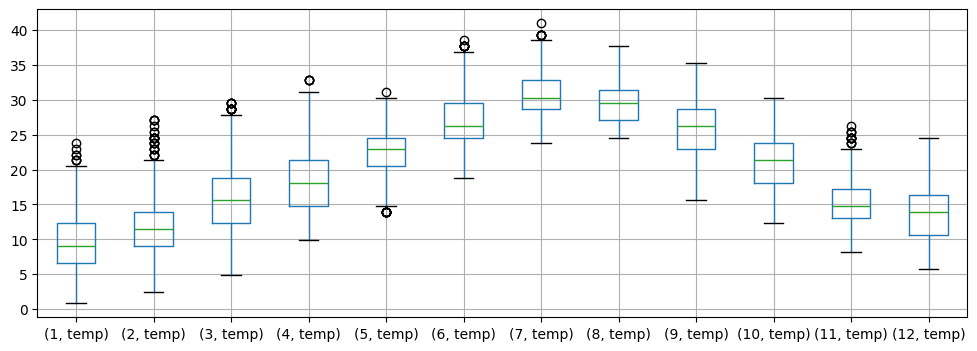

In [70]:
plt.subplots(figsize=(12, 4))

df_pandas_bike.groupby(['month'])[['temp']].boxplot(subplots=False)

plt.show()

## 7. Regressão

> **Incluir o conjunto de dados na entrega do notebook.**
>
> **Os conjuntos de dados devem ser diferentes entre os alunos**

**Dataset escolhido:** [Real Estate Valuation](https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set)

Em uma célula do mesmo notebook crie um texto com markdown, incluindo formatação com títulos, **negrito**, _itálico_ e inclusão de figuras para explicar:


### 7.1. Introdução aos modelos de regressão

* Explique simplificadamente o que é o modelo de regressão e quando estes modelos podem ser utilizados;

### 7.2. Preparação dos dados

In [156]:
REGRESSION_DATASET: Path = download_dataset(
    REGRESSION_DATASET_URL,
    REGRESSION_DATA_PATH,
    'regression.zip'
)

REGRESSION_DATASET

PosixPath('data/regression/regression.zip')

In [157]:
! ls {REGRESSION_DATASET}

data/regression/regression.zip


In [158]:
with ZipFile(REGRESSION_DATASET) as zip_ref:
    zip_ref.extractall(REGRESSION_DATA_PATH)
    zip_ref.close()

In [163]:
regression_csv = glob(f'{REGRESSION_DATA_PATH}/*.xlsx')[0]

regression_csv

'data/regression/Real estate valuation data set.xlsx'

In [166]:
df_regression_real_estate: DataFrame = pd.read_excel(regression_csv)

df_regression_real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [169]:
df_regression_real_estate = df_regression_real_estate.drop(['No',
                                                            'X1 transaction date',
                                                            'X5 latitude',
                                                            'X6 longitude'],
                                                           axis=1)

df_regression_real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X2 house age                            414 non-null    float64
 1   X3 distance to the nearest MRT station  414 non-null    float64
 2   X4 number of convenience stores         414 non-null    int64  
 3   Y house price of unit area              414 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 13.1 KB


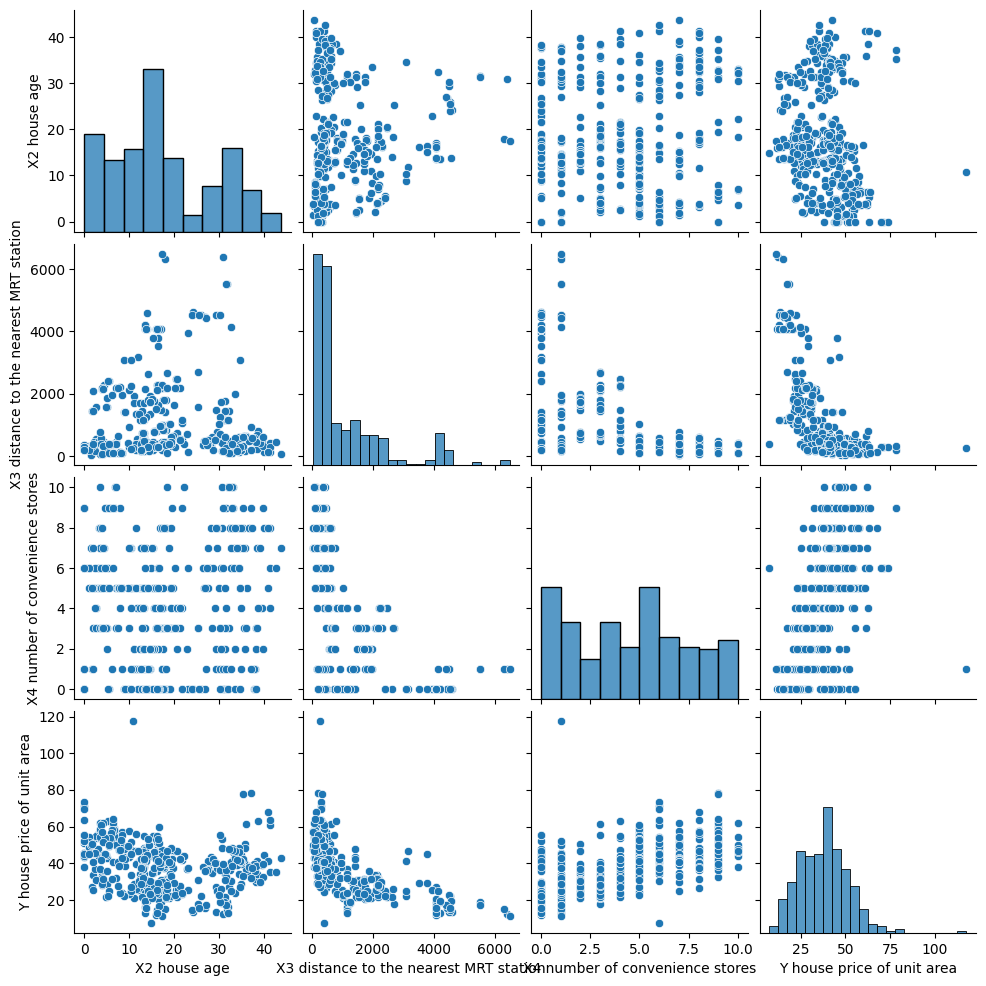

In [170]:
sns.pairplot(df_regression_real_estate)

In [171]:
X_real_estate, y_real_estate = df_regression_real_estate.drop(['Y house price of unit area'], axis=1), df_regression_real_estate['Y house price of unit area']

X_real_estate.shape, y_real_estate.shape

((414, 3), (414,))

In [172]:
X_re_train, X_re_test, y_re_train, y_re_test = train_test_split(X_real_estate, y_real_estate,
                                                                test_size=TEST_RATIO,
                                                                shuffle=True,
                                                                random_state=SEED)

### 7.3. Criando modelos

* Apresente um pequeno exemplo numérico utilizando o que foi aprendido no curso, utilizando um conjunto de dados que não foi visto no curso (pode ser de qualquer lugar na internet) e imprimindo os seguintes resultados:
  * [R2](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)
  * [Coeficientes da regressão](https://www.geeksforgeeks.org/regression-coefficients/)
* E fazendo um gráfico com a variável resposta (eixo `y`) uma das variáveis preditoras (eixo `x`) e a reta da regressão;

#### 7.3.1. [`LinearRegression`](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)

In [176]:
model_linear = LinearRegression()

model_linear.fit(X_re_train, y_re_train)

model_linear

LinearRegression()

In [177]:
pd.DataFrame(model_linear.coef_, 
             X_real_estate.columns, 
             columns=['Coeficientes'])

,Coeficientes
X2 house age,-0.263736
X3 distance to the nearest MRT station,-0.005409
X4 number of convenience stores,1.261937


In [178]:
print('[TRAIN] R2 Score: {:.4f}'.format(r2_score(y_re_train, model_linear.predict(X_re_train))))
print('[TEST] R2 Score: {:.4f}'.format(r2_score(y_re_test, model_linear.predict(X_re_test))))

[TRAIN] R2 Score: 0.5256
[TEST] R2 Score: 0.6279


In [179]:
print('[TRAIN] MSE Score: {:.4f}'.format(mean_squared_error(y_re_train, model_linear.predict(X_re_train))))
print('[TEST] MSE Score: {:.4f}'.format(mean_squared_error(y_re_test, model_linear.predict(X_re_test))))

[TRAIN] MSE Score: 88.1245
[TEST] MSE Score: 66.1812


In [180]:
print('[TRAIN] MRSE Score: {:.4f}'.format(mean_squared_error(y_re_train, model_linear.predict(X_re_train)) ** (1/2)))
print('[TEST] MRSE Score: {:.4f}'.format(mean_squared_error(y_re_test, model_linear.predict(X_re_test)) ** (1/2)))

[TRAIN] MRSE Score: 9.3875
[TEST] MRSE Score: 8.1352


#### 7.3.2. [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/tree.html#regression)

In [182]:
model_tree_reg = DecisionTreeRegressor(max_depth=20,
                                       random_state=SEED)

model_tree_reg.fit(X_re_train, y_re_train)

model_tree_reg

DecisionTreeRegressor(max_depth=20, random_state=42)

In [183]:
print('[TRAIN] R2 Score: {:.4f}'.format(r2_score(y_re_train, model_tree_reg.predict(X_re_train))))
print('[TEST] R2 Score: {:.4f}'.format(r2_score(y_re_test, model_tree_reg.predict(X_re_test))))

[TRAIN] R2 Score: 0.9912
[TEST] R2 Score: 0.5247


In [184]:
print('[TRAIN] MSE Score: {:.4f}'.format(mean_squared_error(y_re_train, model_tree_reg.predict(X_re_train))))
print('[TEST] MSE Score: {:.4f}'.format(mean_squared_error(y_re_test, model_tree_reg.predict(X_re_test))))

[TRAIN] MSE Score: 1.6372
[TEST] MSE Score: 84.5371


In [186]:
print('[TRAIN] MRSE Score: {:.4f}'.format(mean_squared_error(y_re_train, model_tree_reg.predict(X_re_train)) ** (1/2)))
print('[TEST] MRSE Score: {:.4f}'.format(mean_squared_error(y_re_test, model_tree_reg.predict(X_re_test)) ** (1/2)))

[TRAIN] MRSE Score: 1.2795
[TEST] MRSE Score: 9.1944


#### 7.3.3. [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

In [187]:
model_rforest_reg = RandomForestRegressor(max_depth=20,
                                          random_state=SEED)

model_rforest_reg.fit(X_re_train, y_re_train)

model_rforest_reg

RandomForestRegressor(max_depth=20, random_state=42)

In [188]:
print('[TRAIN] R2 Score: {:.4f}'.format(r2_score(y_re_train, model_rforest_reg.predict(X_re_train))))
print('[TEST] R2 Score: {:.4f}'.format(r2_score(y_re_test, model_rforest_reg.predict(X_re_test))))

[TRAIN] R2 Score: 0.9452
[TEST] R2 Score: 0.7744


In [189]:
print('[TRAIN] MSE Score: {:.4f}'.format(mean_squared_error(y_re_train, model_rforest_reg.predict(X_re_train))))
print('[TEST] MSE Score: {:.4f}'.format(mean_squared_error(y_re_test, model_rforest_reg.predict(X_re_test))))

[TRAIN] MSE Score: 10.1864
[TEST] MSE Score: 40.1282


In [190]:
print('[TRAIN] MRSE Score: {:.4f}'.format(mean_squared_error(y_re_train, model_rforest_reg.predict(X_re_train)) ** (1/2)))
print('[TEST] MRSE Score: {:.4f}'.format(mean_squared_error(y_re_test, model_rforest_reg.predict(X_re_test)) ** (1/2)))

[TRAIN] MRSE Score: 3.1916
[TEST] MRSE Score: 6.3347


#### 7.3.4. [`KNeighborsRegressor`](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression)

In [194]:
model_knn_reg = KNeighborsRegressor(n_neighbors=N_NEIGHBORS)

model_knn_reg.fit(X_re_train, y_re_train)

model_knn_reg

KNeighborsRegressor()

In [195]:
print('[TRAIN] R2 Score: {:.4f}'.format(r2_score(y_re_train, model_knn_reg.predict(X_re_train))))
print('[TEST] R2 Score: {:.4f}'.format(r2_score(y_re_test, model_knn_reg.predict(X_re_test))))

[TRAIN] R2 Score: 0.7532
[TEST] R2 Score: 0.6642


In [196]:
print('[TRAIN] MSE Score: {:.4f}'.format(mean_squared_error(y_re_train, model_knn_reg.predict(X_re_train))))
print('[TEST] MSE Score: {:.4f}'.format(mean_squared_error(y_re_test, model_knn_reg.predict(X_re_test))))

[TRAIN] MSE Score: 45.8385
[TEST] MSE Score: 59.7291


In [197]:
print('[TRAIN] MRSE Score: {:.4f}'.format(mean_squared_error(y_re_train, model_knn_reg.predict(X_re_train)) ** (1/2)))
print('[TEST] MRSE Score: {:.4f}'.format(mean_squared_error(y_re_test, model_knn_reg.predict(X_re_test)) ** (1/2)))

[TRAIN] MRSE Score: 6.7704
[TEST] MRSE Score: 7.7285


## 8. Classificação

> **Incluir o conjunto de dados na entrega do notebook.**
>
> **Os conjuntos de dados devem ser diferentes entre os alunos**

**Dataset escolhido**: [Heart Failure Clinical Records](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records)

Em uma célula do mesmo notebook crie um texto com markdown, incluindo formatação com títulos, **negrito**, _itálico_ e inclusão de figuras para explicar:


### 8.1. Introdução aos modelos de classificação

* Explique simplificadamente o que é o modelo de classificação e quando estes modelos podem ser utilizados;

### 8.2. Preparação dos dados

In [141]:
CLASSIFICATION_DATASET: Path = download_dataset(
    CLASSIFICATION_DATASET_URL,
    CLASSIFICATION_DATA_PATH,
    'classification.zip'
)

CLASSIFICATION_DATASET

PosixPath('data/classification/classification.zip')

In [142]:
! ls {CLASSIFICATION_DATASET}

data/classification/classification.zip


In [143]:
with ZipFile(CLASSIFICATION_DATASET) as zip_ref:
    zip_ref.extractall(CLASSIFICATION_DATA_PATH)
    zip_ref.close()

In [80]:
classification_csv = glob(f'{CLASSIFICATION_DATA_PATH}/*.csv')[0]

classification_csv

'data/classification/heart_failure_clinical_records_dataset.csv'

In [81]:
! head -n 3 "{classification_csv}"

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1


In [82]:
df_classification_heart_failure: DataFrame = pd.read_csv(classification_csv)

df_classification_heart_failure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


### 8.3. Criando modelos

* Apresente um pequeno exemplo numérico utilizando o que foi aprendido no curso, utilizando um conjunto de dados que não foi visto no curso (pode ser de qualquer lugar na internet) e imprimindo, utilizando [validação cruzada](https://scikit-learn.org/stable/modules/cross_validation.html), os seguintes resultados:
  * [Acurácia](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score)
  * [Matriz de confusão](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)

#### 8.3.1. [`LogisticRegression`](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

#### 8.3.2. [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/tree.html#classification)

#### 8.3.3. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

#### 8.3.4. [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)

## 9. Agrupamento

> **Incluir o conjunto de dados na entrega do notebook.**
>
> **Os conjuntos de dados devem ser diferentes entre os alunos**

**Dataset escolhido:** [Turkish Music Emotion](https://archive.ics.uci.edu/dataset/862/turkish+music+emotion)

Em uma célula do mesmo notebook crie um texto com markdown, incluindo formatação com títulos, **negrito**, _itálico_ e inclusão de figuras para explicar:


### 9.1. Introdução aos modelos de agrupamento

* Explique simplificadamente o que é o modelo de [Análise de Componentes Principais (_PCA_)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#pca) e quando estes modelos podem ser utilizados;

### 9.2. Preparação dos dados

In [83]:
DECOMPOSITION_DATASET: Path = download_dataset(
    DECOMPOSITION_DATASET_URL,
    DECOMPOSITION_DATA_PATH,
    'decomposition.zip'
)

DECOMPOSITION_DATASET

PosixPath('data/decomposition/decomposition.zip')

In [84]:
! ls {DECOMPOSITION_DATASET}

data/decomposition/decomposition.zip


In [85]:
with ZipFile(DECOMPOSITION_DATASET) as zip_ref:
    zip_ref.extractall(DECOMPOSITION_DATA_PATH)
    zip_ref.close()

In [86]:
decomposition_csv = glob(f'{DECOMPOSITION_DATA_PATH}/*.csv')[0]

decomposition_csv

'data/decomposition/Acoustic Features.csv'

In [87]:
! head -n 3 "{decomposition_csv}"

Class,_RMSenergy_Mean,_Lowenergy_Mean,_Fluctuation_Mean,_Tempo_Mean,_MFCC_Mean_1,_MFCC_Mean_2,_MFCC_Mean_3,_MFCC_Mean_4,_MFCC_Mean_5,_MFCC_Mean_6,_MFCC_Mean_7,_MFCC_Mean_8,_MFCC_Mean_9,_MFCC_Mean_10,_MFCC_Mean_11,_MFCC_Mean_12,_MFCC_Mean_13,_Roughness_Mean,_Roughness_Slope,_Zero-crossingrate_Mean,_AttackTime_Mean,_AttackTime_Slope,_Rolloff_Mean,_Eventdensity_Mean,_Pulseclarity_Mean,_Brightness_Mean,_Spectralcentroid_Mean,_Spectralspread_Mean,_Spectralskewness_Mean,_Spectralkurtosis_Mean,_Spectralflatness_Mean,_EntropyofSpectrum_Mean,_Chromagram_Mean_1,_Chromagram_Mean_2,_Chromagram_Mean_3,_Chromagram_Mean_4,_Chromagram_Mean_5,_Chromagram_Mean_6,_Chromagram_Mean_7,_Chromagram_Mean_8,_Chromagram_Mean_9,_Chromagram_Mean_10,_Chromagram_Mean_11,_Chromagram_Mean_12,_HarmonicChangeDetectionFunction_Mean,_HarmonicChangeDetectionFunction_Std,_HarmonicChangeDetectionFunction_Slope,_HarmonicChangeDetectionFunction_PeriodFreq,_HarmonicChangeDetectionFunction_PeriodAmp,_HarmonicChangeDetectionFunct

In [88]:
df_decomposition: DataFrame = pd.read_csv(decomposition_csv)

df_decomposition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 51 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Class                                           400 non-null    object 
 1   _RMSenergy_Mean                                 400 non-null    float64
 2   _Lowenergy_Mean                                 400 non-null    float64
 3   _Fluctuation_Mean                               400 non-null    float64
 4   _Tempo_Mean                                     400 non-null    float64
 5   _MFCC_Mean_1                                    400 non-null    float64
 6   _MFCC_Mean_2                                    400 non-null    float64
 7   _MFCC_Mean_3                                    400 non-null    float64
 8   _MFCC_Mean_4                                    400 non-null    float64
 9   _MFCC_Mean_5                               

### 9.3. Criando modelos

* Apresente um pequeno exemplo numérico utilizando o que foi aprendido no curso, utilizando um conjunto de dados que não foi visto no curso (pode ser de qualquer lugar na internet) e imprimindo, os seguintes resultados:
  * Variância explicada por cada componente
* Faça um gráfico com os _scores_ do _PCA_ colorindo pelos grupos do seu conjunto de dados.


#### 9.3.1. [`PCA`]()

#### 9.3.2. [`KMeans`](https://scikit-learn.org/stable/modules/clustering.html#k-means)

#### 9.3.3. [`DBSCAN`](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

#### 9.3.4. [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)

## 10. Referências

* [Python Brasil - Lista de Exercícios](https://wiki.python.org.br/ListaDeExercicios)
* [numpy](https://numpy.org/doc/stable/reference/index.html)
* [matplotlib](https://matplotlib.org/stable/api/index)
* [seaborn](https://seaborn.pydata.org/api.html)
* [pandas](https://pandas.pydata.org/docs/reference/index.html#api)
* [scikit-learn](https://scikit-learn.org/stable/api/index.html)
* Datasets:
  * Regressão:
    * Yeh,I-Cheng. (2018). Real Estate Valuation. UCI Machine Learning Repository. https://doi.org/10.24432/C5J30W.
  * Classificação:
    * Heart Failure Clinical Records. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5Z89R.
  * Agrupamento:
    * Er,Mehmet Bilal. (2023). Turkish Music Emotion. UCI Machine Learning Repository. https://doi.org/10.24432/C5JG93.